<a href="https://colab.research.google.com/github/tinayiluo0322/ECE_Final_Project_2025/blob/main/Models/2_Class_Garabge_ResNetCIFAR_Train_From_Scratch_Basic_50_epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIFAR Image Classigication using ResNet


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import sys
import os
import random
import numpy as np
import torch

In [16]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset, random_split, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from collections import Counter
import shutil
from PIL import Image
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm.notebook import tqdm

In [17]:
seed = 42
random.seed(seed)  # Python's random module
np.random.seed(seed)  # NumPy's random module
torch.manual_seed(seed)  # PyTorch's random seed for CPU
torch.cuda.manual_seed(seed)  # PyTorch's random seed for the current GPU
torch.cuda.manual_seed_all(seed)  # PyTorch's random seed for all GPUs (if using multi-GPU)

# Ensure deterministic behavior on GPU (optional, may slow down training)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: Set environment variables for further reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)

### System Check

In [18]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load data

Get the mean and std for train data

Training set

mean: [0.6256342530250549, 0.5870475769042969, 0.5542739629745483]

std: [0.2797325849533081, 0.2854619324207306, 0.2984888553619385]



In [19]:
# import torch
# import numpy as np
# from torchvision import datasets, transforms
# from torch.utils.data.sampler import SubsetRandomSampler
# import os
# from PIL import Image
# from sklearn.model_selection import train_test_split
# from collections import Counter

# # Paths and config
# DATA_PATH = "/content/drive/MyDrive/two_class_garbage-dataset"

# # number of subprocesses to use for data loading
# num_workers = 0
# # how many samples per batch to load
# batch_size = 20

# print('==> Preparing data..')

# # Create the base dataset without any transforms initially
# class GarbageDataset(torch.utils.data.Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform

#         # Define classes with specific indices
#         self.classes = ['non_battery', 'battery']  # Class indices: non_battery=0, battery=1
#         self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

#         self.samples = []
#         # Walk through all files in the directory
#         for class_name in self.classes:
#             class_dir = os.path.join(root_dir, class_name)
#             class_idx = self.class_to_idx[class_name]

#             if not os.path.isdir(class_dir):
#                 print(f"Warning: Directory {class_dir} does not exist!")
#                 continue

#             for root, _, files in os.walk(class_dir):
#                 for file in files:
#                     if file.lower().endswith(('.png', '.jpg', '.jpeg')):
#                         self.samples.append((os.path.join(root, file), class_idx))

#         # Print class distribution information
#         labels = [label for _, label in self.samples]
#         class_counts = Counter(labels)
#         print(f"Dataset class distribution:")
#         for class_idx, count in class_counts.items():
#             print(f"  - {self.classes[class_idx]}: {count} samples")

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         img_path, label = self.samples[idx]
#         image = Image.open(img_path).convert('RGB')
#         if self.transform:
#             image = self.transform(image)
#         return image, label

# # For calculating mean and std, we need a temporary transform
# temp_transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.ToTensor()  # Converts to [0, 1] range
# ])

# # Create a temporary dataset with the temp transform
# temp_dataset = GarbageDataset(root_dir=DATA_PATH, transform=temp_transform)

# # Get all samples and labels for stratification
# all_samples = []
# all_labels = []
# for idx in range(len(temp_dataset)):
#     _, label = temp_dataset[idx]
#     all_labels.append(label)
#     all_samples.append(idx)

# # Print class distribution to verify data is loaded correctly
# print("Overall class distribution in dataset:")
# label_counter = Counter(all_labels)
# for class_idx, count in label_counter.items():
#     class_name = temp_dataset.classes[class_idx]
#     percentage = count / len(all_labels) * 100
#     print(f"  - {class_name} (class {class_idx}): {count} samples ({percentage:.2f}%)")

# # First, perform a stratified split to separate train (80%) and evaluation (20%) data
# train_indices, eval_indices = train_test_split(
#     all_samples,
#     test_size=0.2,
#     random_state=42,
#     stratify=all_labels
# )

# # Get labels for the evaluation set for further stratified splitting
# eval_labels = [all_labels[i] for i in eval_indices]

# # Split the evaluation indices into validation and test sets (50% each of evaluation data)
# valid_indices, test_indices = train_test_split(
#     eval_indices,
#     test_size=0.5,
#     random_state=42,
#     stratify=eval_labels
# )

# print(f"Split proportions: {len(train_indices)}/{len(valid_indices)}/{len(test_indices)} (train/valid/test)")

# # Calculate class distribution to verify stratification
# train_labels = [all_labels[i] for i in train_indices]
# valid_labels = [all_labels[i] for i in valid_indices]
# test_labels = [all_labels[i] for i in test_indices]

# print("Class distribution after stratified split:")
# for i, class_name in enumerate(temp_dataset.classes):
#     train_pct = train_labels.count(i) / len(train_labels) * 100
#     valid_pct = valid_labels.count(i) / len(valid_labels) * 100
#     test_pct = test_labels.count(i) / len(test_labels) * 100

#     print(f"{class_name} (class {i}):")
#     print(f"  - Train: {train_labels.count(i)} samples ({train_pct:.2f}%)")
#     print(f"  - Valid: {valid_labels.count(i)} samples ({valid_pct:.2f}%)")
#     print(f"  - Test:  {test_labels.count(i)} samples ({test_pct:.2f}%)")

# # Create a temporary data loader for just the training portion
# # to calculate mean and std for normalization
# temp_train_dataset = torch.utils.data.Subset(temp_dataset, train_indices)
# temp_train_loader = torch.utils.data.DataLoader(
#     temp_train_dataset, batch_size=64, shuffle=False, num_workers=num_workers
# )

# # Function to calculate mean and std
# def calculate_mean_std(loader):
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0

#     for data, _ in loader:
#         # Mean over batch, height and width, but not over the channels
#         channels_sum += torch.mean(data, dim=[0, 2, 3])
#         channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     std = (channels_squared_sum / num_batches - mean**2)**0.5

#     return mean, std

# print('Calculating dataset mean and std using ONLY the training set...')
# mean, std = calculate_mean_std(temp_train_loader)
# print(f'Training set mean: {mean.tolist()}, std: {std.tolist()}')

### Preprocess train, val, test data

Targeting the unbalanced dataset:

(1) Data Augmentation

- transforms.RandomCrop(32, padding=4),
- transforms.RandomHorizontalFlip(),
- transforms.RandomRotation(15),
- transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

(2) Stratified Splitting

Ensures that each split (train, validation, test) maintains the same class proportions as the original dataset

80% train, 10% val, 10% test

(3) Weighted Sampler

Without any weighting, each sample has an equal probability of being chosen during training. With weighted sampling, we artificially adjust these probabilities to oversample the minority class and undersample the majority class.

In [20]:
import torch
import numpy as np
from torchvision import datasets, transforms
import os
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler

# Paths and config
DATA_PATH = "/content/drive/MyDrive/two_class_garbage-dataset"
num_workers = 2
batch_size = 32

print('==> Preparing data..')

# Use ImageFolder dataset for faster loading
dataset = datasets.ImageFolder(
    DATA_PATH,
    transform=None  # No transforms yet
)

# Define custom class mapping
class_to_idx = {
    'non_battery': 0,
    'battery': 1
}

# Update dataset's class mapping if needed
if dataset.class_to_idx != class_to_idx:
    original_to_new = {v: class_to_idx[k] for k, v in dataset.class_to_idx.items()}
    dataset.class_to_idx = class_to_idx
    dataset.samples = [(path, original_to_new[idx]) for path, idx in dataset.samples]
    dataset.targets = [original_to_new[idx] for idx in dataset.targets]

# Print class information
print("Classes:", dataset.classes)
print("Class to index mapping:", dataset.class_to_idx)

# Get targets for stratification (much faster than loading each image)
targets = np.array(dataset.targets)

# Print class distribution
class_counts = Counter(targets)
print("Dataset class distribution:")
for class_idx, count in class_counts.items():
    class_name = dataset.classes[class_idx]
    percentage = count / len(targets) * 100
    print(f"  - {class_name} (class {class_idx}): {count} samples ({percentage:.2f}%)")

# First split: train vs eval (80/20 split)
train_indices, eval_indices = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,  # 20% for evaluation (will be split into val and test)
    stratify=targets,
    random_state=42
)

# Get labels for the evaluation set for further stratified splitting
eval_targets = targets[eval_indices]

# Second split: validation vs test (50/50 of the eval set, which makes 10/10 of total)
valid_indices, test_indices = train_test_split(
    eval_indices,
    test_size=0.5,  # Split eval set equally between validation and test
    stratify=eval_targets,
    random_state=42
)

print(f"Split proportions: {len(train_indices)}/{len(valid_indices)}/{len(test_indices)} (train/valid/test)")

# Print class distribution after stratified split
train_targets = targets[train_indices]
val_targets = targets[valid_indices]
test_targets = targets[test_indices]

print("Class distribution after stratified split:")
for i, class_name in enumerate(dataset.classes):
    train_pct = np.mean(train_targets == i) * 100
    val_pct = np.mean(val_targets == i) * 100
    test_pct = np.mean(test_targets == i) * 100

    print(f"{class_name} (class {i}):")
    print(f"  - Train: {np.sum(train_targets == i)} samples ({train_pct:.2f}%)")
    print(f"  - Valid: {np.sum(val_targets == i)} samples ({val_pct:.2f}%)")
    print(f"  - Test:  {np.sum(test_targets == i)} samples ({test_pct:.2f}%)")

# Define the transforms with dataset-specific values
MEAN = [0.6256342530250549, 0.5870475769042969, 0.5542739629745483]
STD = [0.2797325849533081, 0.2854619324207306, 0.2984888553619385]

# Define transforms
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Custom wrapper for applying transforms
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create subsets
train_set = TransformedSubset(Subset(dataset, train_indices), transform_train)
val_set = TransformedSubset(Subset(dataset, valid_indices), transform_test)
test_set = TransformedSubset(Subset(dataset, test_indices), transform_test)

# Create weighted sampler for handling class imbalance
class_counts = Counter(train_targets)
weights = 1.0 / np.array([class_counts[t] for t in train_targets])
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

# Prepare data loaders
train_loader = DataLoader(
    train_set, batch_size=batch_size,
    sampler=sampler, num_workers=num_workers
)
valid_loader = DataLoader(
    val_set, batch_size=batch_size,
    shuffle=False, num_workers=num_workers
)
test_loader = DataLoader(
    test_set, batch_size=batch_size,
    shuffle=False, num_workers=num_workers
)

# Specify the image classes
classes = ['non_battery', 'battery']

print(f'Number of training samples: {len(train_set)}')
print(f'Number of validation samples: {len(val_set)}')
print(f'Number of test samples: {len(test_set)}')
print(f'Total samples: {len(dataset)}')

# Function to verify balanced sampling
def check_batch_distribution(loader, num_batches=5):
    class_counts = Counter()
    for i, (_, labels) in enumerate(loader):
        if i >= num_batches:
            break
        class_counts.update(labels.numpy())
    print("Sampled batch class distribution:", dict(class_counts))

print("Checking if WeightedRandomSampler is properly balancing batches:")
check_batch_distribution(train_loader)

==> Preparing data..
Classes: ['battery', 'non_battery']
Class to index mapping: {'non_battery': 0, 'battery': 1}
Dataset class distribution:
  - non_battery (class 1): 944 samples (4.78%)
  - battery (class 0): 18786 samples (95.22%)
Split proportions: 15784/1973/1973 (train/valid/test)
Class distribution after stratified split:
battery (class 0):
  - Train: 15029 samples (95.22%)
  - Valid: 1878 samples (95.18%)
  - Test:  1879 samples (95.24%)
non_battery (class 1):
  - Train: 755 samples (4.78%)
  - Valid: 95 samples (4.82%)
  - Test:  94 samples (4.76%)
Number of training samples: 15784
Number of validation samples: 1973
Number of test samples: 1973
Total samples: 19730
Checking if WeightedRandomSampler is properly balancing batches:
Sampled batch class distribution: {np.int64(0): 77, np.int64(1): 83}


## Show pictures

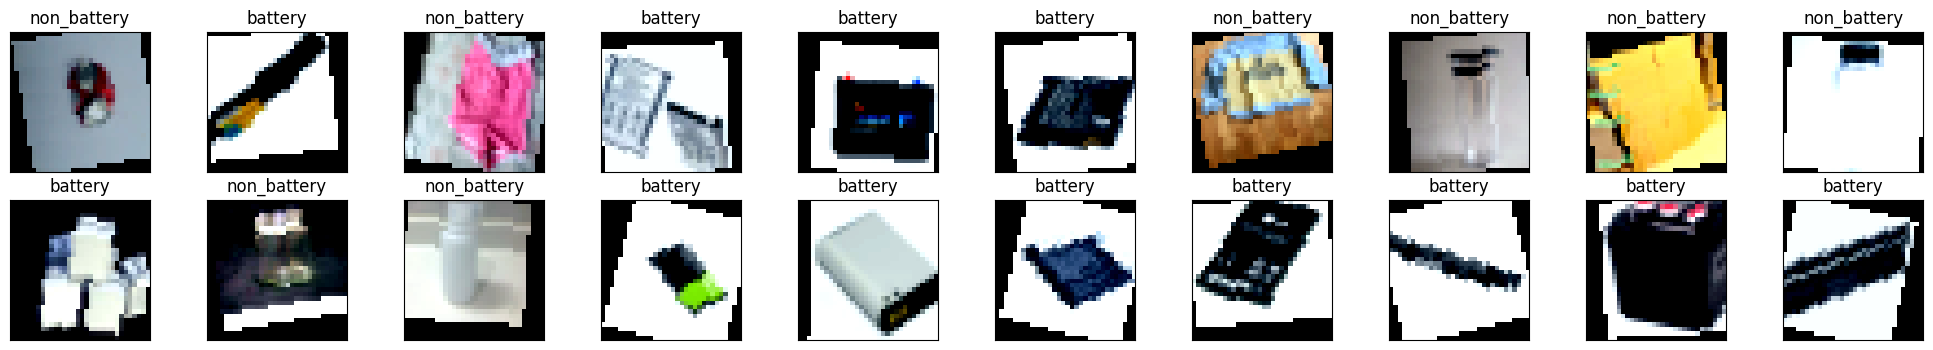

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

### view one image in more detail

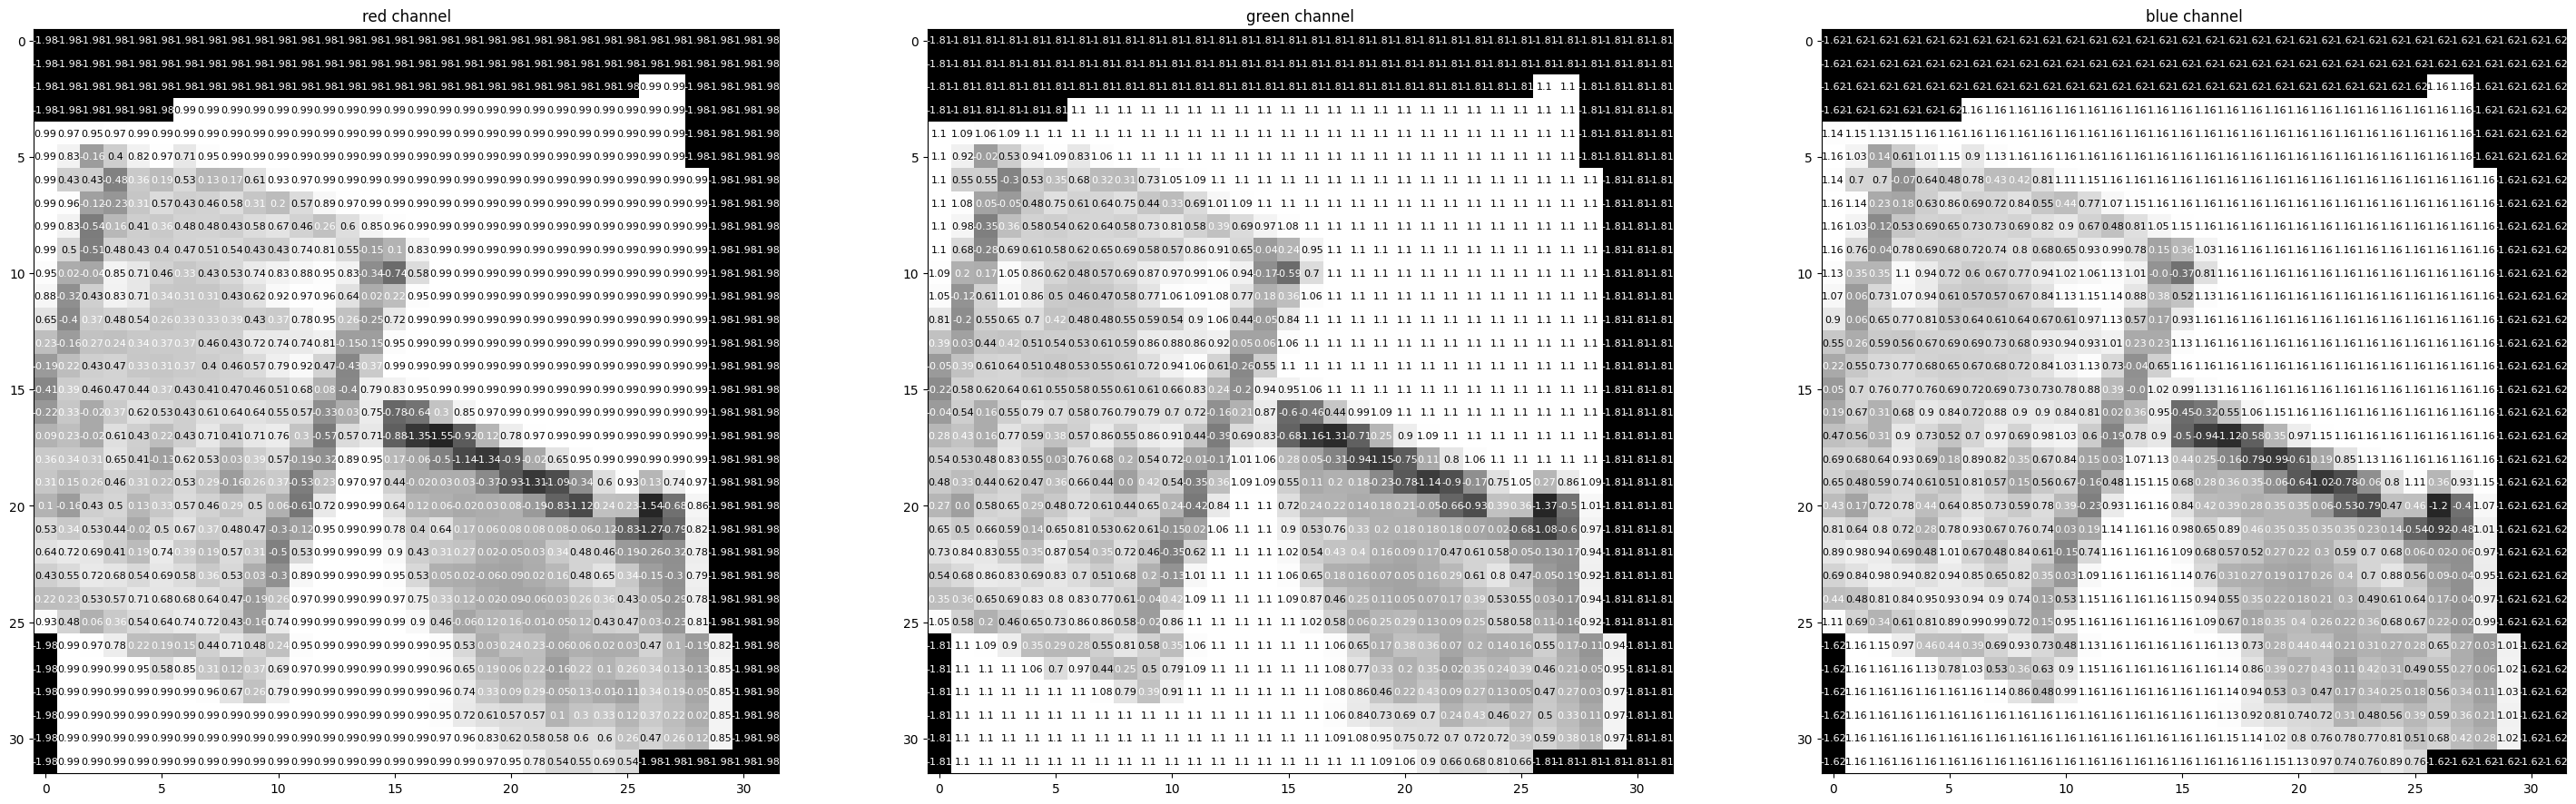

In [22]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1, 3, idx + 1)
  img = rgb_img[idx]
  ax.imshow(img, cmap='gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
    for y in range(height):
      val = round(img[x][y],2) if img[x][y] !=0 else 0
      ax.annotate(str(val), xy=(y,x),
      horizontalalignment='center',
      verticalalignment='center', size=8,
      color='white' if img[x][y]<thresh else 'black')

### Model definition

In [23]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=2):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

ResNet18 = ResNet(BasicBlock, [2,2,2,2])
#ResNet34 = ResNet(BasicBlock, [3,4,6,3])
#ResNet50 = ResNet(BottleNeck, [3,4,6,3])
#ResNet101 = ResNet(BottleNeck, [3,4,23,3])
#ResNet152 = ResNet(BottleNeck, [3,8,36,3])

print(ResNet18)

if train_on_gpu:
  ResNet18 = torch.nn.DataParallel(ResNet18)
  cudnn.benchmark = True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

## Weighted loss

Targeting the unbalanced data:

(4) Weighted Loss

- Assign a higher loss for misclassifications of the minority class (battery)

- Make the model pay more attention to correctly classifying battery samples

- Help balance the influence of each class during training

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter

# Calculate class weights based on the inverse of class frequencies
class_counts = Counter(train_targets)
total_samples = len(train_targets)

# Improved class weight calculation
class_weights = [total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))]
class_weights_tensor = torch.FloatTensor(class_weights)

print(f"Class weights: {class_weights_tensor}")

# Move weights to GPU if using CUDA
if torch.cuda.is_available():
    class_weights_tensor = class_weights_tensor.cuda()

# Weighted CrossEntropyLoss - gives more importance to minority class
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.SGD(ResNet18.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

# Print out class distribution for clarity
print("Class distribution:")
for i, (class_name, count) in enumerate(class_counts.items()):
    percentage = count / total_samples * 100
    print(f"{dataset.classes[i]}: {count} samples ({percentage:.2f}%)")

Class weights: tensor([ 0.5251, 10.4530])
Class distribution:
battery: 15029 samples (95.22%)
non_battery: 755 samples (4.78%)


# train

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1 [0/15784 (0%)]	Loss: 0.416317
Epoch: 1 [640/15784 (4%)]	Loss: 0.207984
Epoch: 1 [1280/15784 (8%)]	Loss: 0.123430
Epoch: 1 [1920/15784 (12%)]	Loss: 0.149293
Epoch: 1 [2560/15784 (16%)]	Loss: 0.153386
Epoch: 1 [3200/15784 (20%)]	Loss: 0.121759
Epoch: 1 [3840/15784 (24%)]	Loss: 0.169103
Epoch: 1 [4480/15784 (28%)]	Loss: 0.166800
Epoch: 1 [5120/15784 (32%)]	Loss: 0.168562
Epoch: 1 [5760/15784 (36%)]	Loss: 0.087549
Epoch: 1 [6400/15784 (40%)]	Loss: 0.097567
Epoch: 1 [7040/15784 (45%)]	Loss: 0.105548
Epoch: 1 [7680/15784 (49%)]	Loss: 0.088390
Epoch: 1 [8320/15784 (53%)]	Loss: 0.279359
Epoch: 1 [8960/15784 (57%)]	Loss: 0.178630
Epoch: 1 [9600/15784 (61%)]	Loss: 0.142134
Epoch: 1 [10240/15784 (65%)]	Loss: 0.237289
Epoch: 1 [10880/15784 (69%)]	Loss: 0.096730
Epoch: 1 [11520/15784 (73%)]	Loss: 0.171719
Epoch: 1 [12160/15784 (77%)]	Loss: 0.136474
Epoch: 1 [12800/15784 (81%)]	Loss: 0.092119
Epoch: 1 [13440/15784 (85%)]	Loss: 0.151954
Epoch: 1 [14080/15784 (89%)]	Loss: 0.068000
Epoch: 1 [1

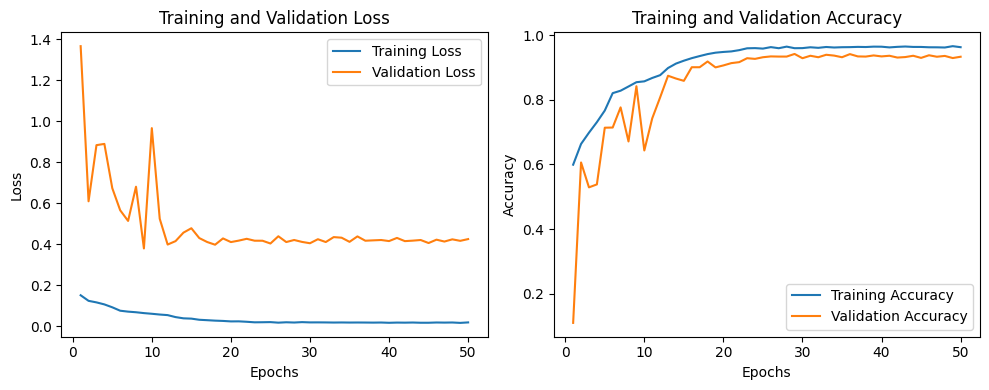

In [26]:
import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Number of epochs to train the model
n_epochs = 50

# Learning rate scheduler to reduce LR when validation performance plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

# Track best model and metrics
valid_loss_min = np.inf
best_epoch = 0
best_accuracy = 0  # Track accuracy

# Initialize arrays to store metrics history
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(1, n_epochs+1):
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Keep track of predictions and targets for metrics
    train_preds = []
    train_targets = []
    valid_preds = []
    valid_targets = []

    ###################
    # Train the model #
    ###################
    ResNet18.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = ResNet18(data)

        # Calculate the batch loss with class weights (already in criterion)
        loss = criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * data.size(0)

        # Get predictions for metrics
        _, preds = torch.max(output, 1)
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(target.cpu().numpy())

        # Print progress (every 20 batches)
        if batch_idx % 20 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.sampler)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    ######################
    # Validate the model #
    ######################
    ResNet18.eval()
    with torch.no_grad():  # Disable gradient calculation for validation
        for batch_idx, (data, target) in enumerate(valid_loader):
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = ResNet18(data)

            # Calculate the batch loss
            loss = criterion(output, target)

            # Update average validation loss
            valid_loss += loss.item() * data.size(0)

            # Get predictions for metrics
            _, preds = torch.max(output, 1)
            valid_preds.extend(preds.cpu().numpy())
            valid_targets.extend(target.cpu().numpy())

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    # Calculate metrics
    train_accuracy = accuracy_score(train_targets, train_preds)
    valid_accuracy = accuracy_score(valid_targets, valid_preds)

    # Calculate precision, recall and f1 for both classes
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        train_targets, train_preds, average=None, labels=[0, 1]
    )
    valid_precision, valid_recall, valid_f1, _ = precision_recall_fscore_support(
        valid_targets, valid_preds, average=None, labels=[0, 1]
    )

    # Calculate confusion matrices
    train_cm = confusion_matrix(train_targets, train_preds)
    valid_cm = confusion_matrix(valid_targets, valid_preds)

    # Store metrics for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    # Print training/validation statistics
    print(f'\nEpoch: {epoch}/{n_epochs}')
    print(f'Training Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    print(f'Training Accuracy: {train_accuracy:.4f} \tValidation Accuracy: {valid_accuracy:.4f}')

    # Print metrics for each class
    print('\nTraining Metrics by Class:')
    print(f'Class\t\tPrecision\tRecall\t\tF1-Score')
    print(f'non_battery\t{train_precision[0]:.4f}\t\t{train_recall[0]:.4f}\t\t{train_f1[0]:.4f}')
    print(f'battery\t\t{train_precision[1]:.4f}\t\t{train_recall[1]:.4f}\t\t{train_f1[1]:.4f}')

    print('\nValidation Metrics by Class:')
    print(f'Class\t\tPrecision\tRecall\t\tF1-Score')
    print(f'non_battery\t{valid_precision[0]:.4f}\t\t{valid_recall[0]:.4f}\t\t{valid_f1[0]:.4f}')
    print(f'battery\t\t{valid_precision[1]:.4f}\t\t{valid_recall[1]:.4f}\t\t{valid_f1[1]:.4f}')

    # Print confusion matrices
    print("\nTraining Confusion Matrix:")
    print(train_cm)
    print("\nValidation Confusion Matrix:")
    print(valid_cm)

    # Full classification reports
    print("\nDetailed Training Classification Report:")
    print(classification_report(train_targets, train_preds, target_names=['non_battery', 'battery']))

    print("\nDetailed Validation Classification Report:")
    print(classification_report(valid_targets, valid_preds, target_names=['non_battery', 'battery']))

    # Update learning rate based on validation loss
    scheduler.step(valid_loss)

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(ResNet18.state_dict(), '/content/drive/MyDrive//ECE661 final project/ResNet18_2_class_garbage_train_50.pt')
        valid_loss_min = valid_loss
        best_epoch = epoch

    print('-' * 80)  # Print a line for better readability between epochs

print(f"Training complete. Best validation loss: {valid_loss_min:.6f} at epoch {best_epoch}")

# Plot training history
plt.figure(figsize=(10, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, n_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# load best

In [27]:
# ResNet18.load_state_dict(torch.load('ResNet18.pt'))

In [28]:
# # track test loss
# test_loss = 0.0
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))

# ResNet18.eval()
# # iterate over test data
# for batch_idx, (data, target) in enumerate(test_loader):
#   # move tensors to GPU if CUDA is available
#   if train_on_gpu:
#     data, target = data.cuda(), target.cuda()
#   # forward pass: compute predicted outputs by passing inputs to the model
#   output = ResNet18(data)
#   # calculate the batch loss
#   loss = criterion(output, target)
#   # update test loss
#   test_loss += loss.item()*data.size(0)
#   # convert output probabilities to predicted class
#   _, pred = torch.max(output, 1)
#   # compare predictions to true label
#   correct_tensor = pred.eq(target.data.view_as(pred))
#   correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
#   # calculate test accuracy for each object class
#   for i in range(batch_size):
#     label = target.data[i]
#     class_correct[label] += correct[i].item()
#     class_total[label] += 1

# # average test loss
# test_loss = test_loss/len(test_loader.dataset)
# print('Test Loss: {:.6f}\n'.format(test_loss))

# for i in range(10):
#   if class_total[i] > 0:
#     print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#         classes[i], 100 * class_correct[i] / class_total[i],
#         np.sum(class_correct[i]), np.sum(class_total[i])))
#   else:
#     print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
#     100. * np.sum(class_correct) / np.sum(class_total),
#     np.sum(class_correct), np.sum(class_total)))

Test Accuracy: 0.8581

Test Metrics by Class:
Class		Precision	Recall		F1-Score
non_battery	0.9950		0.8552		0.9199
battery		0.2402		0.9149		0.3805

Test Confusion Matrix:
[[1607  272]
 [   8   86]]

Detailed Test Classification Report:
              precision    recall  f1-score   support

 non_battery       1.00      0.86      0.92      1879
     battery       0.24      0.91      0.38        94

    accuracy                           0.86      1973
   macro avg       0.62      0.89      0.65      1973
weighted avg       0.96      0.86      0.89      1973



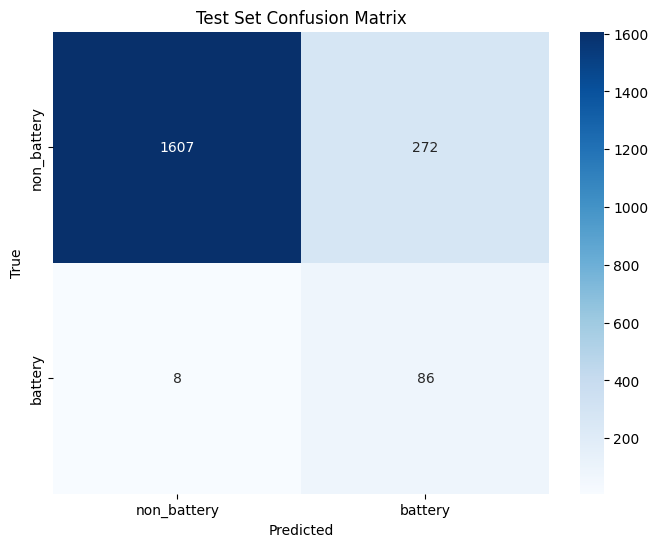


Additional Metrics:
Specificity (True Negative Rate): 0.8552
Sensitivity (True Positive Rate): 0.9149
Precision: 0.2402
F1 Score for battery class: 0.3805


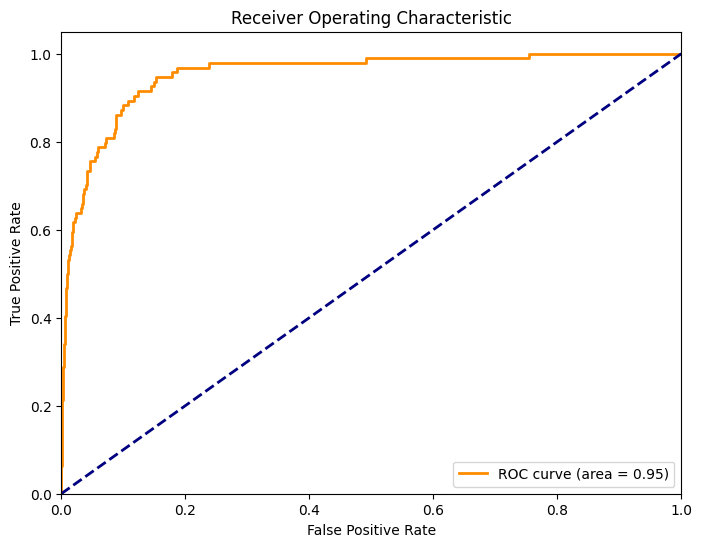

In [29]:
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# Load the saved model
model_path = '/content/drive/MyDrive//ECE661 final project/ResNet18_2_class_garbage_train_50.pt'  # Path to your saved model

# Initialize the model with the same architecture
ResNet18 = ResNet(BasicBlock, [2,2,2,2], num_classes=2)

# Handle loading from DataParallel model if needed
if train_on_gpu:
    ResNet18 = ResNet18.cuda()
    state_dict = torch.load(model_path)
    # If the model was saved with DataParallel
    if list(state_dict.keys())[0].startswith('module.'):
        ResNet18 = torch.nn.DataParallel(ResNet18)
        ResNet18.load_state_dict(state_dict)
    else:
        ResNet18.load_state_dict(state_dict)
else:
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    # If the model was saved with DataParallel but we're loading on CPU
    if list(state_dict.keys())[0].startswith('module.'):
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove 'module.' prefix
            new_state_dict[name] = v
        ResNet18.load_state_dict(new_state_dict)
    else:
        ResNet18.load_state_dict(state_dict)

# Set model to evaluation mode
ResNet18.eval()

# Initialize variables to store predictions and ground truth
test_preds = []
test_targets = []

# Evaluate on test set
with torch.no_grad():  # Disable gradient calculation for evaluation
    for data, target in test_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = ResNet18(data)

        # Get predictions
        _, preds = torch.max(output, 1)

        # Collect all predictions and targets
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(target.cpu().numpy())

# Calculate metrics
test_accuracy = accuracy_score(test_targets, test_preds)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    test_targets, test_preds, average=None, labels=[0, 1]
)
test_cm = confusion_matrix(test_targets, test_preds)

# Print results
print(f'Test Accuracy: {test_accuracy:.4f}')

print('\nTest Metrics by Class:')
print(f'Class\t\tPrecision\tRecall\t\tF1-Score')
print(f'non_battery\t{test_precision[0]:.4f}\t\t{test_recall[0]:.4f}\t\t{test_f1[0]:.4f}')
print(f'battery\t\t{test_precision[1]:.4f}\t\t{test_recall[1]:.4f}\t\t{test_f1[1]:.4f}')

print("\nTest Confusion Matrix:")
print(test_cm)

print("\nDetailed Test Classification Report:")
print(classification_report(test_targets, test_preds, target_names=['non_battery', 'battery']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['non_battery', 'battery'],
            yticklabels=['non_battery', 'battery'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.savefig('test_confusion_matrix.png')
plt.show()

# Calculate and print some additional metrics
tn, fp, fn, tp = test_cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # Same as recall for positive class
precision = tp / (tp + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print("\nAdditional Metrics:")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score for battery class: {f1:.4f}")

# Plot ROC curve if want probability outputs rather than just class predictions
# This requires modifying the prediction loop to get probability outputs
if True:  # Set to True if want to compute ROC curve
    from sklearn.metrics import roc_curve, auc

    # We need to rerun predictions to get probabilities
    test_probs = []
    with torch.no_grad():
        for data, _ in test_loader:
            if train_on_gpu:
                data = data.cuda()
            output = ResNet18(data)
            probs = torch.nn.functional.softmax(output, dim=1)
            test_probs.extend(probs[:, 1].cpu().numpy())  # Probability for class 1 (battery)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(test_targets, test_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()